##Red Neuronal (2 capas) desde cero

##Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


##Importar Mnist

In [2]:
!pip install mnist

In [3]:
import mnist

In [4]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.3 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving Get_Images.py to Get_Images.py
/content/drive/MyDrive/Deep Learning/mnist_raw.idx3-ubyte
/content/drive/MyDrive/Deep Learning/train-images-idx3-ubyte.gz
/content/drive/MyDrive/Deep Learning/train-labels-idx1-ubyte.gz
/content/drive/MyDrive/Deep Learning/t10k-images-idx3-ubyte.gz
/content/drive/MyDrive/Deep Learning/t10k-labels-idx1-ubyte.gz
/content/drive/MyDrive/Deep Learning/Get_Images.py
/content/drive/MyDrive/Deep Learning/red_neuronal1.ipynb
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
La imagen mostrada corresponde a un : 7


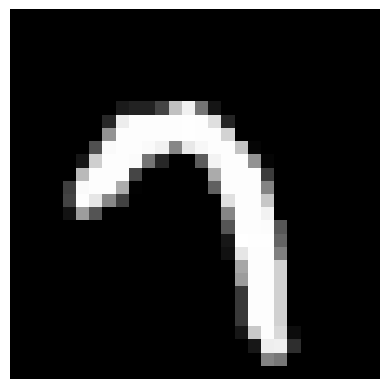

In [6]:
from google.colab import files
src = list(files.upload().values())[0]
open('Get_Images.py','wb').write(src)
import Get_Images

In [8]:
# Importacion de funcion get_images desde archivo Get_Images.py
from Get_Images import get_images

In [9]:
mnist.path = '/content/drive/MyDrive/Deep Learning/mnist_raw'

In [10]:
print(mnist.path)

/content/drive/MyDrive/Deep Learning/mnist_raw


In [11]:
# Importa las variables desde el archivo Get_images.py
from Get_Images import x_train, y_train, x_test, y_test

# Crea las nuevas variables
x_train_num = x_train
y_train_num = y_train
x_test_num = x_test
y_test_num = y_test

In [12]:
# Creacion de variables y resize de imagenes
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)/255
y_test = y_test_num.copy().reshape(10000, 1)

<ipython-input-12-80ed83926e7d>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)/255
<ipython-input-12-80ed83926e7d>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)/255


In [13]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


##Graficar algunas imagenes

In [14]:
def plot_number(image):
  plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()

La imagen muestreada representa un: [0]


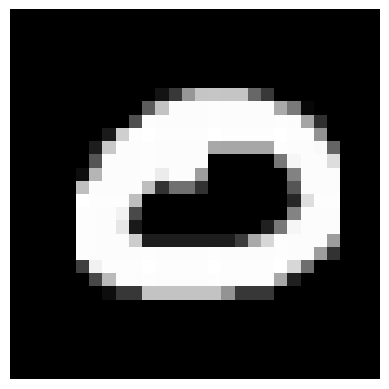

In [15]:
                            ##Busqueda de nro random
rnd_idx = np.random.randint(len(y_test))
                            ##Comentario
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
                            ##Importacion de imagen
plot_number(x_test_num[rnd_idx])

##Red Neuronal

##Dos capas 200-10

##Crear mini batches

In [16]:
x_train.shape[0]

50000

In [17]:
                             ##Creacion de minibatches##

def create_minibatches(mb_size, x, y, shuffle = True):

    # x  #muestras, 784
    # y #muestras, 1

    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

##Init parameters

In [18]:
def init_parameters(input_size, neurons):

    # input_size -> elementos de entrada, 784
    # neurons -> list [200, 10] con cantidad de neuronas en cada capa

    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))

    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))

    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}


In [19]:
#Prueba de parametros
parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)

(200, 784)
(10, 200)
(10, 1)


In [20]:
def relu(x):
  return np.maximum(0, x)

In [21]:
def linear_pass(x, parameters, activation_fcn):

    #¤ x tiene la forma (#pixeles, num samples)

    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']

    return z2, z1, a1

In [22]:
linear_pass,z1, a1 = linear_pass(x_train[:64].T, parameters, relu)

In [23]:
x_train[:64].shape

(64, 784)

In [24]:
linear_pass.shape

(10, 64)

In [25]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

In [26]:
def x_entropy(linear_pass, y, batch_size=64):
    probs = softmax(linear_pass)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    return probs, cost

In [27]:
def backward(probs, x, y, z1, a1, linear_pass, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()

    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0

    dW1 = dz1 @ x
    db1 = np.sum(dz1, axis=1, keepdims=True)

    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'

    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}

    return grads

In [28]:
y_hat, cost = x_entropy(linear_pass, y_train[:64])

In [29]:
y_hat.shape

(10, 64)

In [30]:
print(cost)

2.30258803824968


In [31]:
grads = backward(y_hat, x_train[:64], y_train[:64],z1, a1, linear_pass, parameters)

In [32]:
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = linear_pass(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))

        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [33]:
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = linear_pass(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))

            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']

        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters

In [34]:
print(type(linear_pass))

<class 'numpy.ndarray'>


In [37]:
mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

TypeError: ignored

In [ ]:
accuracy(x_train, y_train, mb_size)

In [ ]:
accuracy(x_test, y_test, mb_size)

In [ ]:
def predict(x):
    scores2, _, _ = linear_pass(x, parameters, relu)
    return np.argmax(scores2)

In [ ]:
x_test[0].reshape(-1, 1).shape

In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')